In [8]:
import os
import glob

train_images_link = glob.glob('C:\\Users\\yytt\\Desktop\\dacon\\train_imgs' + '\\*.'+ 'png')

In [9]:
from PIL import Image

size_list = []
size_x_list = []
size_y_list = []

for t_image in train_images_link:
    image = Image.open(t_image)
    size_list.append(image.size)
    size_x_list.append(image.size[0])
    size_y_list.append(image.size[1])

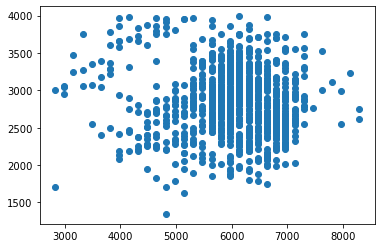

In [10]:
import matplotlib.pyplot as plt

plt.scatter(size_x_list,size_y_list)

In [11]:
test_images_link = glob.glob('C:/Users/yytt/Desktop/dacon/test_imgs' + '/*.'+ 'png')

In [12]:
from PIL import Image

test_size_list = []
test_size_x_list = []
test_size_y_list = []

for t_image in test_images_link:
    image = Image.open(t_image)
    test_size_list.append(image.size)
    test_size_x_list.append(image.size[0])
    test_size_y_list.append(image.size[1])

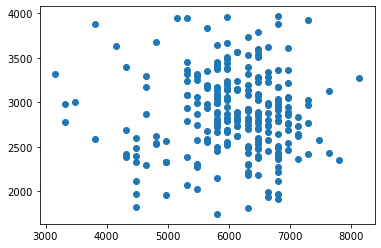

In [13]:
plt.scatter(test_size_x_list,test_size_y_list)

In [14]:
mean_train_x = sum(size_x_list) // len(size_x_list)
mean_train_y = sum(size_y_list) // len(size_y_list)
mean_test_x = sum(test_size_x_list) // len(test_size_x_list)
mean_test_y = sum(test_size_y_list) // len(test_size_y_list)

train_row = mean_train_x // 224
train_col = mean_train_y // 224

test_row = mean_test_x // 224
test_col = mean_test_y // 224

print(mean_train_x,mean_train_y ,mean_test_x ,mean_test_y )
print(train_row, train_col , train_row * train_col)
print(test_row , test_col , test_row * test_col)

6003 2850 6062 2873
26 12 312
27 12 324


In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 31 19:51:35 2022

@author: jsyoon
"""

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import cv2
import os
# from spectral import *
#%% opening
def bwareaopen(img, min_size, connectivity=8):
        """Remove small objects from binary image (approximation of
        bwareaopen in Matlab for 2D images).
   
        Args:
            img: a binary image (dtype=uint8) to remove small objects from
            min_size: minimum size (in pixels) for an object to remain in the image
            connectivity: Pixel connectivity; either 4 (connected via edges) or 8 (connected via edges and corners).
   
        Returns:
            the binary image with small objects removed
        """
   
        # Find all connected components (called here "labels")
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            img, connectivity=connectivity)
       
        # check size of all connected components (area in pixels)
        for i in range(num_labels):
            label_size = stats[i, cv2.CC_STAT_AREA]
           
            # remove connected components smaller than min_size
            if label_size < min_size:
                img[labels == i] = 0
               
        return img
#%% tiling
def window_nd(a, window, steps = None):
    ashp = np.array(a.shape)
    wshp = np.array(window).reshape(-1)
    if steps:
        stp = np.array(steps).reshape(-1)
    else:
        stp = np.ones_like(ashp)
    astr = np.array(a.strides)
    assert np.all(np.r_[ashp.size == wshp.size, wshp.size == stp.size, wshp <= ashp])
    shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
    strides = tuple(astr * stp) + tuple(astr)
    as_strided = np.lib.stride_tricks.as_strided
    aview = as_strided(a, shape = shape, strides = strides)
    return aview

In [16]:
k = 26 * 12 
k

312

In [24]:
#%%
# path_p = 'train_imgs'
# path_p = 'test_imgs'

for path_p in ['C:\\Users\\yytt\\Desktop\\dacon\\train_imgs','C:\\Users\\yytt\\Desktop\\dacon\\test_imgs']:
    save_path = path_p+'_wsi'
    #%%
    data_list = sorted(glob.glob(path_p+'/*.png'))
    dnum = len(data_list)
    #print(data_list)
    patch_size = 224
   
    for data_info in tqdm(data_list,desc= 'Current:'+path_p):
    # data_info = data_list[9]
        #print(data_info)
        file_name_full = data_info.split('\\')[-1]
        #print(file_name_full)
        file_name, _ = file_name_full.split('.')
        #print(file_name)
        #w, h  = patch_size*16,patch_size*8 
        w, h  = patch_size*26,patch_size*12 # 하이퍼 파라미터
        img = cv2.imread(data_info)
        img = cv2.resize(img, (w, h))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
           
        # img_patch = np.reshape(img_g, (patch_size,15,patch_size,7))
        # img_patch = np.transpose(img_patch,(0,2,1,3))
        # img_patch = np.reshape(img_patch, (patch_size,patch_size,15*7))
        # imshow(img_patch)
           
        #%%
        #img_t = window_nd(img_g, (224, 224), (224, 224))
        img_t = window_nd(img_g, (224, 224), (224, 224)) # fixed to color
        
        img_t = img_t.copy().reshape(-1, 224, 224) #to match expected output
        img_t = np.transpose(img_t,(2,1,0))
        cnum = np.size(img_t,2)
        bw_s=[]
        for idx in range(cnum):
            img_i = img_t[:,:,idx]
            # bw_i = cv2.adaptiveThreshold(img_i,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
            # bw_i = 255-bw_i
            bw_i = cv2.GaussianBlur(img_t[:,:,idx], (0, 0), 2)<220        
            bw_i = bwareaopen(np.uint8(bw_i*255),20)
            bw_i = bw_i>250
            bw_s.append(bw_i.sum())
        #%%
#         sort_index = np.argsort(bw_s)
#         sort_index = sort_index[::-1]
#         # plt.plot(np.array(bw_s)[sort_index])
#         img_t_new = img_t[:,:,sort_index]
#         img_t_new = img_t_new[:,:,:k] # 하이퍼 파라미터
        
        #         sort_index = np.argsort(bw_s)
#         sort_index = sort_index[::-1]
#         # plt.plot(np.array(bw_s)[sort_index])
#         img_t_new = img_t[:,:,sort_index]    # fixed
        img_t_new = img_t
#        img_t_new = img_t_new[:,:,:k] # 하이퍼 파라미터
        # imshow(z_new)
    
        # imshow(z_new)
        os.makedirs(save_path, exist_ok=True)
        save_name = save_path+'/'+file_name+'.npy'
        np.save(save_name, img_t_new) # save .npy

Current:C:\Users\yytt\Desktop\dacon\train_imgs:   1%|▎                                | 9/1000 [00:03<06:48,  2.43it/s]


KeyboardInterrupt: 

(224, 224, 312)


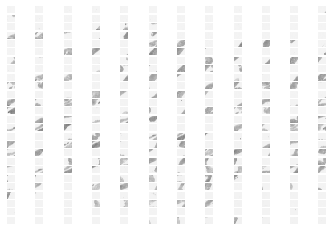

In [22]:
loaded_test_img = np.load('C:\\Users\\yytt\\Desktop\\dacon\\train_imgs_wsi\\BC_01_3330.npy')

print(loaded_test_img.shape)

for i in range(k):
    #img = Image.fromarray(loaded_test_img[:,:,i])
    img = loaded_test_img[:,:,i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(26,12,i+1)
    plt.axis('off')
    plt.imshow(img)
